# 词向量实验：Word2Vec 与 GloVe (基于 PyTorch 实现)

本实验利用金庸小说语料（请放在您指定的本地文件夹）进行词向量训练。实验使用两种模型：

1. **Word2Vec**（使用 gensim 库）
2. **GloVe**（采用 PyTorch 实现，不依赖 glove 库）

实验流程：

- 数据加载与预处理（利用 jieba 对中文文本分词）
- 模型训练：Word2Vec 与 GloVe（PyTorch 版）
- 定量对比：计算测试词对的余弦相似度并输出表格
- 聚类分析：对词向量进行 KMeans 聚类，计算轮廓系数，并利用 PCA 降维后展示散点图

**依赖安装说明**：

请确保安装以下依赖库：

- 安装 PyTorch（视环境安装 CPU 或 GPU 版本，例如）：
  ```
  pip install torch torchvision torchaudio
  ```

- 其他依赖：
  ```
  pip install gensim jieba scikit-learn matplotlib pandas numpy
  ```


In [2]:
import os
import glob
import re
import jieba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

## 1. 参数配置

请修改 `data_path` 为存放金庸小说语料的文件夹路径，其他参数均可根据需求调整。

In [4]:
# 请修改 data_path 为实际语料存放文件夹路径
data_path = 'D:\小说数据集'  # 例如: './data/jinyong/'

# Word2Vec 模型参数
w2v_params = {
    'vector_size': 100,
    'window': 5,
    'min_count': 5,
    'workers': 4,
    'epochs': 10
}

# GloVe 模型参数（PyTorch 实现）
glove_params = {
    'no_components': 100,      # 词向量维度
    'learning_rate': 0.05,
    'epochs': 10,
    'window_size': 5,
    'batch_size': 512,
    'x_max': 100,
    'alpha': 0.75
}

# 聚类参数
n_clusters = 5  

# 测试用词（可根据需要调整）
test_words = ['郭靖', '黄蓉', '降龙', '九阳', '天下']

## 2. 数据加载与预处理

从指定文件夹中加载所有文本文件，利用正则表达式按中文标点分句，再用 jieba 分词。

In [6]:
def load_corpus(path, encoding_list=['utf-8', 'gb18030']):
    """
    加载指定文件夹下所有文本文件，并按中文标点（。！？）分句。
    尝试使用 encoding_list 中的编码格式依次读取，直到成功为止。
    """
    files = glob.glob(os.path.join(path, '*.txt'))
    sentences = []
    for file in files:
        success = False
        for enc in encoding_list:
            try:
                with open(file, 'r', encoding=enc) as f:
                    text = f.read()
                success = True
                break
            except UnicodeDecodeError:
                continue
        if not success:
            print(f"无法解码文件: {file}，请检查文件编码。")
            continue
        # 根据中文标点切分句子
        sents = re.split('[。！？]', text)
        sentences.extend([s.strip() for s in sents if s.strip() != ''])
    return sentences

# 加载语料
raw_sentences = load_corpus(data_path)
print(f"加载的句子数: {len(raw_sentences)}")

# 分词：对每个句子使用 jieba 进行分词
tokenized_sentences = [list(jieba.cut(sentence)) for sentence in raw_sentences]
print(f"分词后的句子数: {len(tokenized_sentences)}")

Building prefix dict from the default dictionary ...


加载的句子数: 274217


Dumping model to file cache C:\Users\Dell\AppData\Local\Temp\jieba.cache
Loading model cost 0.768 seconds.
Prefix dict has been built successfully.


分词后的句子数: 274217


## 3. 训练 Word2Vec 模型

使用 gensim 库训练 Word2Vec 模型。

In [8]:
print("训练 Word2Vec 模型...")
w2v_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=w2v_params['vector_size'],
    window=w2v_params['window'],
    min_count=w2v_params['min_count'],
    workers=w2v_params['workers'],
    epochs=w2v_params['epochs']
)
print("Word2Vec 模型训练完成。")

训练 Word2Vec 模型...
Word2Vec 模型训练完成。


## 4. 训练 GloVe 模型（使用 PyTorch 实现）

下面实现了 GloVe 模型：

- **构建词汇表**：统计所有单词频次，并保留频次大于等于 min_count 的词汇。
- **构建共现矩阵**：遍历每个句子，利用指定窗口计算每对词的共现权重（采用 1/距离 加权）。
- **定义 GloVe 模型**：模型包含两个嵌入矩阵（目标词和上下文词）及相应偏置，最终词向量取两者之和。
- **训练过程**：采用经典 GloVe 损失函数，并使用 Adam 优化器进行优化。

In [10]:
from collections import Counter, defaultdict

def build_vocab(tokenized_sentences, min_count):
    """构建词汇表，返回 word_to_idx 及 idx_to_word 列表"""
    counter = Counter()
    for sentence in tokenized_sentences:
        counter.update(sentence)
    vocab = {word: count for word, count in counter.items() if count >= min_count}
    sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
    idx_to_word = [word for word, count in sorted_vocab]
    word_to_idx = {word: idx for idx, word in enumerate(idx_to_word)}
    return word_to_idx, idx_to_word

def build_cooccurrence(tokenized_sentences, word_to_idx, window_size):
    """构建共现字典，key=(i, j)，value 为共现权重（距离倒数加权）"""
    cooccurrence = defaultdict(float)
    for sentence in tokenized_sentences:
        # 筛选词汇
        indices = [word_to_idx[word] for word in sentence if word in word_to_idx]
        for i, center in enumerate(indices):
            left = max(0, i - window_size)
            right = min(len(indices), i + window_size + 1)
            for j in range(left, right):
                if i != j:
                    distance = abs(i - j)
                    weight = 1.0 / distance
                    cooccurrence[(center, indices[j])] += weight
    return cooccurrence

# 构建词汇表（使用与 Word2Vec 同样的 min_count）
word_to_idx, idx_to_word = build_vocab(tokenized_sentences, w2v_params['min_count'])
vocab_size = len(idx_to_word)
print(f"词汇表大小: {vocab_size}")

# 构建共现矩阵
cooccurrence = build_cooccurrence(tokenized_sentences, word_to_idx, glove_params['window_size'])
print(f"共现对数量: {len(cooccurrence)}")

class GloveModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(vocab_size, embedding_dim)
        self.wj = nn.Embedding(vocab_size, embedding_dim)
        self.bi = nn.Embedding(vocab_size, 1)
        self.bj = nn.Embedding(vocab_size, 1)
        nn.init.xavier_uniform_(self.wi.weight)
        nn.init.xavier_uniform_(self.wj.weight)
        nn.init.zeros_(self.bi.weight)
        nn.init.zeros_(self.bj.weight)

    def forward(self, i_indices, j_indices):
        vi = self.wi(i_indices)
        vj = self.wj(j_indices)
        bi = self.bi(i_indices).squeeze()
        bj = self.bj(j_indices).squeeze()
        dot = torch.sum(vi * vj, dim=1)
        return dot + bi + bj

def train_glove(cooccurrence, vocab_size, embedding_dim, epochs, learning_rate, x_max, alpha, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GloveModel(vocab_size, embedding_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 将共现数据转换为列表 [(i, j, X_ij), ...]
    data = [(i, j, count) for (i, j), count in cooccurrence.items()]
    data_len = len(data)
    
    for epoch in range(epochs):
        np.random.shuffle(data)
        total_loss = 0
        for batch_start in range(0, data_len, batch_size):
            batch = data[batch_start: batch_start + batch_size]
            i_indices = torch.tensor([d[0] for d in batch], dtype=torch.long, device=device)
            j_indices = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
            counts = torch.tensor([d[2] for d in batch], dtype=torch.float, device=device)
            
            # 计算权重 f(x)
            f = torch.pow(torch.clamp(counts / x_max, max=1.0), alpha)
            log_counts = torch.log(counts)
            
            optimizer.zero_grad()
            output = model(i_indices, j_indices)
            loss = torch.mean(f * (output - log_counts) ** 2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(batch)
        avg_loss = total_loss / data_len
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    # 最终词向量为目标词和上下文词向量之和
    embeddings = model.wi.weight.data + model.wj.weight.data
    return embeddings.cpu().numpy()

# 训练 GloVe 模型
print("训练 GloVe 模型 (PyTorch 实现)...")
glove_embeddings, model_unused = None, None  # 占位
glove_embeddings = train_glove(
    cooccurrence=cooccurrence,
    vocab_size=vocab_size,
    embedding_dim=glove_params['no_components'],
    epochs=glove_params['epochs'],
    learning_rate=glove_params['learning_rate'],
    x_max=glove_params['x_max'],
    alpha=glove_params['alpha'],
    batch_size=glove_params['batch_size']
)
print("GloVe 模型训练完成。")

# 保存 GloVe 词向量和对应词汇
glove_word_vectors = glove_embeddings
glove_words = idx_to_word

词汇表大小: 46282
共现对数量: 10452772
训练 GloVe 模型 (PyTorch 实现)...
Epoch 1/10, Loss: 23.2016
Epoch 2/10, Loss: 49.9938
Epoch 3/10, Loss: 55.8893
Epoch 4/10, Loss: 58.0872
Epoch 5/10, Loss: 59.3063
Epoch 6/10, Loss: 59.5566
Epoch 7/10, Loss: 60.0621
Epoch 8/10, Loss: 60.3685
Epoch 9/10, Loss: 60.3893
Epoch 10/10, Loss: 60.3458
GloVe 模型训练完成。


## 5. 定量评估：计算词对余弦相似度对比

对选定的测试词（例如：郭靖、黄蓉等），分别从 Word2Vec 和 GloVe 模型中提取词向量，计算它们的余弦相似度，并将结果保存为 CSV 表格。

In [12]:
from scipy.spatial.distance import cosine

def get_vector(model_type, word):
    if model_type == 'w2v':
        try:
            return w2v_model.wv[word]
        except KeyError:
            return None
    elif model_type == 'glove':
        if word in glove_words:
            idx = glove_words.index(word)
            return glove_word_vectors[idx]
        else:
            return None

results = []
for i in range(len(test_words)):
    for j in range(i+1, len(test_words)):
        w1 = test_words[i]
        w2 = test_words[j]
        
        vec1_w2v = get_vector('w2v', w1)
        vec2_w2v = get_vector('w2v', w2)
        sim_w2v = 1 - cosine(vec1_w2v, vec2_w2v) if (vec1_w2v is not None and vec2_w2v is not None) else None
        
        vec1_glove = get_vector('glove', w1)
        vec2_glove = get_vector('glove', w2)
        sim_glove = 1 - cosine(vec1_glove, vec2_glove) if (vec1_glove is not None and vec2_glove is not None) else None
        
        results.append({
            'Word1': w1,
            'Word2': w2,
            'Cosine_Sim_Word2Vec': sim_w2v,
            'Cosine_Sim_GloVe': sim_glove
        })

df_similarity = pd.DataFrame(results)
print("词对余弦相似度对比:")
print(df_similarity)
df_similarity.to_csv('cosine_similarity_comparison.csv', index=False)

词对余弦相似度对比:
  Word1 Word2  Cosine_Sim_Word2Vec  Cosine_Sim_GloVe
0    郭靖    黄蓉             0.868962          0.055814
1    郭靖    降龙            -0.153624         -0.035973
2    郭靖    九阳             0.136275         -0.079265
3    郭靖    天下            -0.162967         -0.033873
4    黄蓉    降龙            -0.249989          0.130562
5    黄蓉    九阳             0.044457         -0.002160
6    黄蓉    天下            -0.236394         -0.077756
7    降龙    九阳             0.579174          0.010138
8    降龙    天下             0.333870         -0.152374
9    九阳    天下             0.230825         -0.028683


## 6. 聚类分析与可视化

从 Word2Vec 与 GloVe 模型中分别提取前 500 个词的词向量，使用 KMeans 进行聚类，并计算轮廓系数。接着利用 PCA 将词向量降至二维后绘制散点图。

Word2Vec 轮廓系数: 0.0297
GloVe 轮廓系数: 0.0636
Word2Vec 聚类结果（前10行）:
  word  cluster
0    ，        1
1    的        4
2    ：        3
3    了        3
4    “        3
5    ”        1
6    　        1
7    他        4
8    是        3
9    道        2
GloVe 聚类结果（前10行）:
  word  cluster
0    ，        2
1    的        2
2    ：        2
3    了        2
4    “        2
5    ”        2
6    　        2
7    他        2
8    是        2
9    道        2


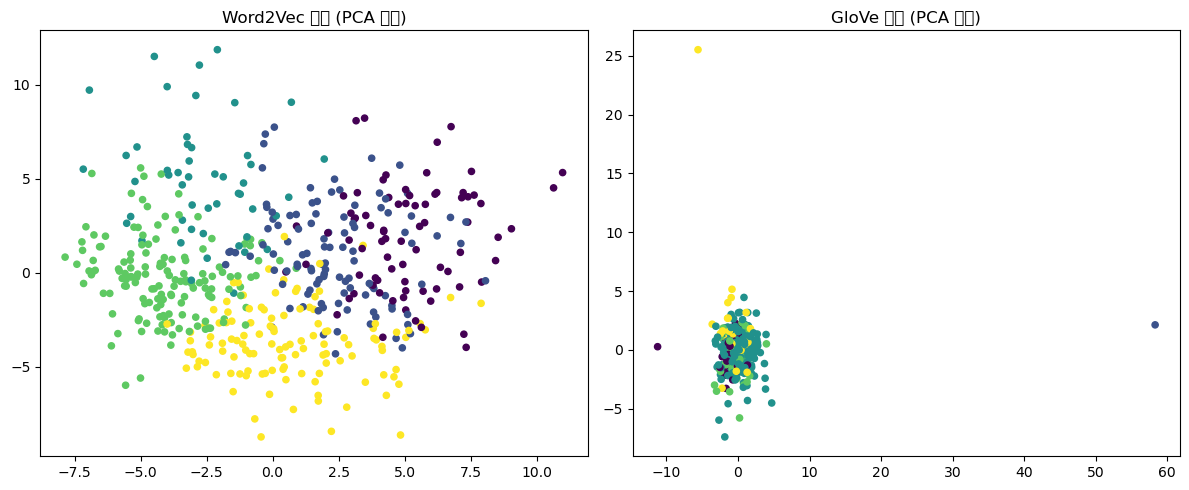

In [14]:
def get_model_embeddings(model_type='w2v', top_n=500):
    if model_type == 'w2v':
        words = w2v_model.wv.index_to_key[:top_n]
        vectors = np.array([w2v_model.wv[word] for word in words])
    elif model_type == 'glove':
        words = glove_words[:top_n]
        vectors = np.array([glove_word_vectors[i] for i in range(min(top_n, len(glove_word_vectors)))])
    return words, vectors

# 提取词向量
words_w2v, vecs_w2v = get_model_embeddings(model_type='w2v', top_n=500)
words_glove, vecs_glove = get_model_embeddings(model_type='glove', top_n=500)

# 聚类
kmeans_w2v = KMeans(n_clusters=n_clusters, random_state=42).fit(vecs_w2v)
kmeans_glove = KMeans(n_clusters=n_clusters, random_state=42).fit(vecs_glove)

# 计算轮廓系数
silhouette_w2v = silhouette_score(vecs_w2v, kmeans_w2v.labels_)
silhouette_glove = silhouette_score(vecs_glove, kmeans_glove.labels_)

print(f"Word2Vec 轮廓系数: {silhouette_w2v:.4f}")
print(f"GloVe 轮廓系数: {silhouette_glove:.4f}")

df_clusters_w2v = pd.DataFrame({'word': words_w2v, 'cluster': kmeans_w2v.labels_})
df_clusters_glove = pd.DataFrame({'word': words_glove, 'cluster': kmeans_glove.labels_})

print("Word2Vec 聚类结果（前10行）:")
print(df_clusters_w2v.head(10))
print("GloVe 聚类结果（前10行）:")
print(df_clusters_glove.head(10))

pca = PCA(n_components=2, random_state=42)
reduced_w2v = pca.fit_transform(vecs_w2v)
reduced_glove = pca.fit_transform(vecs_glove)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(reduced_w2v[:,0], reduced_w2v[:,1], c=kmeans_w2v.labels_, cmap='viridis', s=20)
plt.title('Word2Vec 聚类 (PCA 降维)')

plt.subplot(1,2,2)
plt.scatter(reduced_glove[:,0], reduced_glove[:,1], c=kmeans_glove.labels_, cmap='viridis', s=20)
plt.title('GloVe 聚类 (PCA 降维)')

plt.tight_layout()
plt.savefig('clustering_comparison.png')
plt.show()

## 总结

本实验中，我们分别利用 Word2Vec 和基于 PyTorch 实现的 GloVe 对金庸小说语料训练了词向量，并通过以下方式对模型进行了评估：

- **词向量相似度比较**：针对测试词对（例如 "郭靖"与"黄蓉"），计算它们之间的余弦相似度，并输出比较表格；

- **聚类分析**：对提取的高频词词向量进行 KMeans 聚类，计算轮廓系数，并利用 PCA 降维后绘制散点图进行可视化；

最后，各种定量指标、表格数据及统计图均保存至本地文件，方便后续对比和分析。